In [1]:
from qepy import *
from yambopy import *
from qepy import PwIn
import matplotlib.pyplot as plt
import numpy as np
import GW_Routines as GW
import TD_Routines as TD

In [2]:
mpi = 8 #16 #32
omp = 1

## Time dependent analysis 

Define the basis parameters of the RT simulation common to all the computation. Different values of the field intensity are considered and the yambo dictionary contains a key which parametrize this quantity.

In [3]:
fieldFreq = 2.56 #eV
fieldWidth = 20 #fs
fieldDirection = [1.0,1.0,1.0]
RTstep = 1.0 #as - time step
NETime = 120.0 #fs - total simulation time
RTbands = [2,7] # the KS bands involved in the simulation

In [4]:
# contains the parameters of the yambo_rt input file
rt_parameters = {
     'Field1_Freq'  : [[fieldFreq,fieldFreq],'eV'],
     'Field1_Width' : [fieldWidth,'fs'],
     'Field1_kind'  : 'QSSIN',
     'Field1_pol'   : 'linear',
     'Field1_Dir'   : fieldDirection,
     'RTstep'       : [RTstep,'as'],
     'NETime'       : [NETime,'fs'],
     'RTBands'      : RTbands,
     'IOtime'       : [[1.0,5.0,1.0],'fs'], # Carriers - GF - output
     'GfnQP_Wv'     : [0.05,0.00,0.00],     # Constant damping valence
     'GfnQP_Wc'     : [0.05,0.00,0.00],     # Constant damping conduction
     #'GfnQP_E'      : [0.00, 1.00, 1.00], 
     'RT_CPU'       : "%s.1.1.1"%mpi
}
#rt_parameters

In [5]:
# Set the values of the intensity of the field
fieldInt = [1.,100.,200.]  #kWLm2

Choose a value of kpoints and the direction of the perturbing field. Create the fixSymm folder that contain the SAVE folder compatible with the simmetries broken by the perturbation. This folder is working path of the RT simulation. Create the yambo dictionary.

In [6]:
kfold = 'yambo/k8'
path = TD.fixSymm(kfold,fieldDirection)
print 'path : ',path

FixSymm folder already created
path :  yambo/k8/FixSymm


In [7]:
yambo = dict()
for f in fieldInt:
    yambo[f] = {}
yambo

{1.0: {}, 100.0: {}, 200.0: {}}

In [8]:
reload(TD)
TD.build_rt_dictionary(yambo,path,rt_parameters)
#yambo

In [9]:
reload(TD)
TD.run_rt(yambo,path,mpi,omp,True)
TD.get_rt_results(yambo)

skip the computation for :  yambo/k8/FixSymm/rt_int200_freq2.56_step1.0/o-rt_int200_freq2.56_step1.0.carriers
skip the computation for :  yambo/k8/FixSymm/rt_int1_freq2.56_step1.0/o-rt_int1_freq2.56_step1.0.carriers
skip the computation for :  yambo/k8/FixSymm/rt_int100_freq2.56_step1.0/o-rt_int100_freq2.56_step1.0.carriers
parsing file :  yambo/k8/FixSymm/rt_int200_freq2.56_step1.0/o-rt_int200_freq2.56_step1.0.carriers
parsing file :  yambo/k8/FixSymm/rt_int200_freq2.56_step1.0/o-rt_int200_freq2.56_step1.0.external_field
parsing file :  yambo/k8/FixSymm/rt_int1_freq2.56_step1.0/o-rt_int1_freq2.56_step1.0.carriers
parsing file :  yambo/k8/FixSymm/rt_int1_freq2.56_step1.0/o-rt_int1_freq2.56_step1.0.external_field
parsing file :  yambo/k8/FixSymm/rt_int100_freq2.56_step1.0/o-rt_int100_freq2.56_step1.0.carriers
parsing file :  yambo/k8/FixSymm/rt_int100_freq2.56_step1.0/o-rt_int100_freq2.56_step1.0.external_field


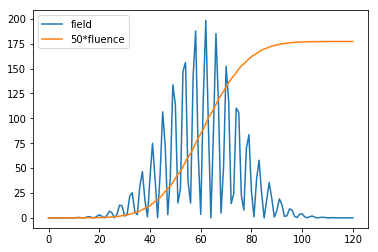

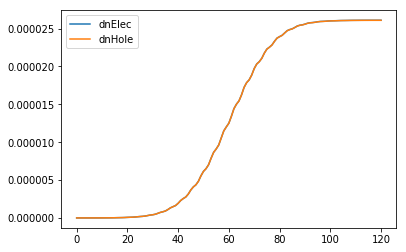

In [10]:
f = 200
y = yambo[f]['rt']['results']

plt.plot(y['time'],y['field_int'],label='field')
plt.plot(y['time'],50*np.array(y['fluence']),label='50*fluence')
plt.legend()
plt.show()

plt.plot(y['time'],y['dnElec'],label='dnElec')
plt.plot(y['time'],y['dnHoles'],label='dnHole')
plt.legend()
plt.show()

## Analysis of the ypp post-processing for rt simulations

We choose one (or several) calculations among the rt results and use ypp_rt to perform the post-processing. The chosen computation is defined by the dictionary called study

In [11]:
study = yambo[200]['rt']

In [12]:
reload(TD)
TD.build_ypp_noe(path,study)

remove file : yambo/k8/FixSymm/ypp.in
cd yambo/k8/FixSymm; ypp_rt -n o e -V qp


In [13]:
TD.run_noe(path,study)
TD.get_ypp_noe_results(study)

delete yambo/k8/FixSymm/ypp_noe_int200_freq2.56_step1.0
execute : cd yambo/k8/FixSymm; OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt -F ypp.in -J rt_int200_freq2.56_step1.0 -C ypp_noe_int200_freq2.56_step1.0
done!
parsing file :  yambo/k8/FixSymm/ypp_noe_int200_freq2.56_step1.0/o-rt_int200_freq2.56_step1.0.YPP-RT_occupations_DATA


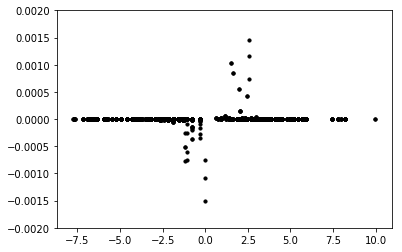

In [14]:
y = study['noe']['results']
for e,o in zip(y['energy'],y['occupations']):
    plt.scatter(e,o,color='black',s = 10)
plt.ylim(ymin=-2e-3,ymax=2e-3)
plt.show()

## COHSEX simulation using the non-equilibrium occupations

Take the starting point of the COHSEX calculation from the converged parameters of the HF ones and set the parameter for the cs computation (choose the 'converged ones' found in the eq analysis

In [38]:
# Parameters of the cs_rt input file
g0_gcomp = 3.0 #Ha
w_gcomp = 5.0 #Ha
w_nbnds = 50
firstk = 1
lastk = 21 # the k index to compute the indirect band gap
firstbnd = 2
lastbnd = 7

cs_parameters = {
    'EXXRLvcs'    : [1000.0*g0_gcomp,'mHa'],
    'NGsBlkXs'    : [1000.0*w_gcomp,'mHa'],
    'BndsRnXs'    : [1,w_nbnds],
    'QPkrange'    : [[firstk,lastk]+[firstbnd,lastbnd],'']
}

In [39]:
reload(TD)
TD.build_cs_rt(yambo,path,cs_parameters,time=100)

In [40]:
yambo[200]['cs']

{100: {'inpf': 'cs_int200_freq2.56_time100.in',
  'jobn': 'cs_int200_freq2.56_time100',
  'outf': 'yambo/k8/FixSymm/cs_int200_freq2.56_time100/o-cs_int200_freq2.56_time100.qp'}}

In [18]:
TD.run_cs_rt(yambo,path,mpi,omp,True)

skip the computation for :  yambo/k8/FixSymm/cs_int200_freq2.56_time100/o-cs_int200_freq2.56_time100.qp
skip the computation for :  yambo/k8/FixSymm/cs_int1_freq2.56_time100/o-cs_int1_freq2.56_time100.qp
skip the computation for :  yambo/k8/FixSymm/cs_int100_freq2.56_time100/o-cs_int100_freq2.56_time100.qp


In [19]:
TD.get_cs_rt_results(yambo)

read file :  yambo/k8/FixSymm/cs_int200_freq2.56_time100/o-cs_int200_freq2.56_time100.qp
read file :  yambo/k8/FixSymm/cs_int1_freq2.56_time100/o-cs_int1_freq2.56_time100.qp
read file :  yambo/k8/FixSymm/cs_int100_freq2.56_time100/o-cs_int100_freq2.56_time100.qp


In [35]:
# print the direct and indirect band gaps in function of the field intensity
print 'Direct gap'
for f in fieldInt:
    print f, GW.getBandGap(yambo[f]['cs']['results'],4,5,1,1)
print 'Indirect gap'
for f in fieldInt:
    print f, GW.getBandGap(yambo[f]['cs']['results'],4,5,1,21)

#for f in fieldInt:
#    plt.scatter(f,GW.getBandGap(yambo[f]['cs']['results'],4,5,1,21))
#plt.show()

Direct gap
1.0 3.321092
100.0 3.320987
200.0 3.320872
Indirect gap
1.0 1.667868
100.0 1.667792
200.0 1.667703


The value at lowest field is not in agreement with the eq result and the gaps do not scale properly with the field intensity. Things to do:
* repeat the calculation without specifying the neq occupations. With the chose values for g0_gcomp, w_gcomp and w_nbnds the eq simulations provide 1.773 and 3.667 for the indirect and direct band gaps respectively 

In [62]:
# Prepare a specific dictionary to run the eq cs computation using the same procedures of the neq ones
radical = 'cs_eq'
inpf = radical+'.in'
outf = path+'/'+radical+'/'+'o-'+radical+'.qp'
cs_eq = {0:{'cs':{0:{'inpf':'cs_eq.in','jobn':'cs_eq','outf':outf}}}}
TD.make_cs_rt_input(path,fname = cs_eq[0]['cs'][0]['inpf'],**cs_parameters)

In [63]:
cs_eq

{0: {'cs': {0: {'inpf': 'cs_eq.in',
    'jobn': 'cs_eq',
    'outf': 'yambo/k8/FixSymm/cs_eq/o-cs_eq.qp'}}}}

In [64]:
reload(TD)
TD.run_cs_rt(cs_eq,path,mpi,omp,True)

execute :  cd yambo/k8/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 8 yambo_rt -F cs_eq.in -J cs_eq -C cs_eq
done!


In [66]:
TD.get_cs_rt_results(cs_eq)

read file :  yambo/k8/FixSymm/cs_eq/o-cs_eq.qp


In [68]:
GW.getBandGap(cs_eq[0]['cs']['results'],4,5,1,21)

1.667792

In [ ]:
#######################################################################################

Per andare avanti.
Guardare nella cartella di yambo-tests
/home/marco/Data/RICERCA/MANY BODY/Test/yambo-tests/TESTS/MAIN/Si_bulk/RT/INPUTS
dove ci sono vari file di input da studiare. In particolare

* si possono generare distribuzioni neq con ypp_rt (anche se ora non mi serve visto che l'ho fatto esplicitamente con il conto rt). Questo è descritto nei file di input 02_carriers_DB_ypp (credo) e si genera con ypp_rt -C (da controllare da -H di ypp_rt)
* fare post processing dei conti rt con ypp_rt. In questo caso si fa ypp_rt -n o e (tutto da controllare) e si generano file tipo 02_carriers_Fermi_fit_DB. Poi con ypp_rt -F <nomefile> -J <nomefoldercontoRT> si ottiene il plot 
* conto COHSEX con occupazioni neq (si fanno conti di tipo COHSEX perchè l'estensione eq->neq funziona in modo semplice solo se la Sigma è reale (o statica?)). Guardare l'input file 08_cohsex_10fs. E' un conto COHSEX standard con la stringa in più
    
    GfnRTdb= "f @ 0.1 ps < <folderconto RT>/ndb.RT_carriers"          # [EXTRT G] Database

la f indica le occupazioni

Now perform a COHSEX calculation on top on the neq distribution

In [135]:
# take the starting point of the COHSEX calculation from the converged parameters of the HF ones
hf_kconv = 8
hf_G0_Gcompconv = 3.0 #Ha

In [136]:
yambo_eq = {8 : {'folder' :'yambo/k8'}}
yambo_neq = {8 : {'folder' :'yambo/k8/FixSymm'}}

In [137]:
W_Gcomp = [5.0] #Ha
W_nb = [50]
# compute the COHSEX correction only for the bands in the range
firstk = 1
lastk = 21 # the k index to compute the indirect band gap
firstbnd = 2
lastbnd = 7

In [138]:
GW.buildCOHSEX(yambo_eq,hf_kconv,hf_G0_Gcompconv,W_Gcomp,W_nb,firstk,lastk,firstbnd,lastbnd)
GW.buildCOHSEX(yambo_neq,hf_kconv,hf_G0_Gcompconv,W_Gcomp,W_nb,firstk,lastk,firstbnd,lastbnd)

In [63]:
# add manually the string
GfnRTdb= "f @ 0.1 ps < rt_field100_step1.0-bnd2-7/ndb.RT_carriers" # [EXTRT G] Database

In [64]:
# l'ho eseguito con yambo dovevo usare yambo_rt? credo sia la stessa cosa...

In [139]:
GW.runCOHSEX(yambo_neq,hf_kconv,mpi,omp,True)
GW.getCOHSEXresults(yambo_neq,hf_kconv)

execute : cd yambo/k8/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 8 yambo -F cs_wGcomp5.0_wNb50.in -J cs_wGcomp5.0_wNb50 -C cs_wGcomp5.0_wNb50
done!
read file : yambo/k8/FixSymm/cs_wGcomp5.0_wNb50/o-cs_wGcomp5.0_wNb50.qp


In [140]:
# reload the computation for the equilibrium case
GW.runCOHSEX(yambo_eq,hf_kconv,mpi,omp,True)
GW.getCOHSEXresults(yambo_eq,hf_kconv)

skip the computation for : yambo/k8/cs_wGcomp5.0_wNb50/o-cs_wGcomp5.0_wNb50.qp
read file : yambo/k8/cs_wGcomp5.0_wNb50/o-cs_wGcomp5.0_wNb50.qp


In [141]:
results_neq = yambo_neq[8]['cs'][(5.0,50)]['results']
results_eq = yambo_eq[8]['cs'][5.0,50]['results']

In [142]:
print 'equilibrium indirect gap = ', GW.getBandGap(results_eq,4,5,1,21)
print 'non-equilibrium indirect gap = ', GW.getBandGap(results_neq,4,5,1,21)

equilibrium indirect gap =  1.773443
non-equilibrium indirect gap =  1.742104


In [143]:
# mi sembra che il risultato neq non sia dipendente dall'intensità del campo...

In [ ]:
# modifica di ven 30/11 ore 15.02